# Setup

In [34]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Tuple
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [35]:
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from transformers import AutoTokenizer, AutoModel

In [189]:
# switch model here: BERT, DeBERTa, RoBERTa
model_name = "all-mpnet-base-v2"
# switch between balanced and full dataset
balanced = True
run_ID = 9

Time formatting function

In [37]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Set random seed values for reproducibility

In [38]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Introduce GPU

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Read the data

In [40]:
train = pd.read_json('C:/Users/MZywi/Documents/Uni/MSc2/msp/adept/train-dev-test-split/train.json')
dev = pd.read_json('C:/Users/MZywi/Documents/Uni/MSc2/msp/adept/train-dev-test-split/val.json')
test = pd.read_json('C:/Users/MZywi/Documents/Uni/MSc2/msp/adept/train-dev-test-split/test.json')

train['set'] = 'train'
dev['set'] = 'dev'
test['set'] = 'test'
df = pd.concat([train, dev, test])

In [41]:
df.head()

,sentence1,sentence2,modifier,noun,label,idx,set
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484,train
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620,train
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324,train
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610,train
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917,train


In [42]:
df['set'].value_counts()

set
train    12892
test      1612
dev       1611
Name: count, dtype: int64

Only keep label classes 1, 2 and 3 (comparison labels). Map them to 0, 1 and 2 for training convenience:

* 1 => 0
* 2 => 1
* 3 => 2

In [43]:
df = df[df['label'].isin([1, 2, 3])]
df['label'].value_counts()

label
2    10805
1     1868
3     1132
Name: count, dtype: int64

In [44]:
# map the labels to numbers between 1 and 0
df['label'] = df['label'] * 0.5
df['label'] -= 0.5
df['label'].value_counts()

label
0.5    10805
0.0     1868
1.0     1132
Name: count, dtype: int64

Filter out duplicated data points

In [45]:
df = df.drop_duplicates(subset=['sentence2'], keep='first')
df['label'].value_counts()

label
0.5    10800
0.0     1866
1.0     1129
Name: count, dtype: int64

Balance the training data by randomly sampling 1500 examples from class 1

In [46]:
train = df[df['set'] == 'train']
dev = df[df['set'] == 'dev']
test = df[df['set'] == 'test']

In [47]:
train['label'].value_counts()

label
0.5    8631
0.0    1503
1.0     926
Name: count, dtype: int64

In [48]:
if balanced:
    train = pd.concat([
        train[train['label'].isin([0, 1])],
        train[train['label'] == 0.5].sample(1500, random_state=seed_val)
    ])
train['label'].value_counts()

label
0.0    1503
0.5    1500
1.0     926
Name: count, dtype: int64

In [49]:
train.shape

(3929, 7)

Save the data frame to make the results reproducible

In [50]:
#train.to_csv(f'{mount}/datasets/adept/train_comparison_balanced.csv', index=False)

In [51]:
#train = pd.read_csv(f'{mount}/datasets/adept/train_comparison_balanced.csv')
#train.head()

In [52]:
df = pd.concat([train, dev, test])
df.reset_index(inplace=True, drop=True)
df.shape

(6664, 7)

# Tokenization

Our text input for the model will be sentence1 and sentence2 concatenated. Let's generate that input

In [53]:
df['sent_concat'] = df.apply(lambda row: InputExample(texts=[row['sentence1'], row['sentence2']], label=row['label']), axis=1)

Load tokenizer

In [54]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2', do_lower_case=True)

Now let's calculate max input document length in tokens

In [55]:
# max_len = 0
# for doc in df['sent_concat']:
#     input_ids = tokenizer.encode(doc, add_special_tokens=True)
#     max_len = max(max_len, len(input_ids))
# max_len

Apply the tokenization function to the data

In [57]:
# train
train_docs = df[df['set'] == 'train']['sent_concat'].to_list()

# validation (dev)
dev_docs = df[df['set'] == 'dev']['sent_concat'].to_list()

# test
test_docs = df[df['set'] == 'dev']['sent_concat'].to_list()

Create a `torch` dataset and dataloader to conveniently load it into the model

In [26]:
batch_size = 16

# train
train_dataloader = DataLoader(
            train_docs,
            sampler=RandomSampler(train_docs),  # Select batches randomly
            batch_size=batch_size
        )

# validation (dev)
validation_dataloader = DataLoader(
            dev_docs,
            sampler=SequentialSampler(dev_docs),  # Pull out batches sequentially
            batch_size=batch_size
        )

print(f'train:  {len(train_docs)} data points, {len(train_dataloader)} batches')
print(f'validation (dev): {len(dev_docs)} data points, {len(validation_dataloader)} batches')

train:  3929 data points, 246 batches
validation (dev): 1355 data points, 85 batches


# Model

In [27]:
# match model_name:
#     case "BERT":
#         from transformers import BertForSequenceClassification
#     case "DeBERTa":
#         from transformers import DebertaForSequenceClassification
#     case "RoBERTa":
#         from transformers import RobertaForSequenceClassification
#     case _:
#         from transformers import BertForSequenceClassification

from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [28]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
model.cuda()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8  # default
                )

train_loss = losses.CosineSimilarityLoss(model=model)

# Training

## Training loop

In [32]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

model_name = 'all-mpnet-base-v2'
train_batch_size = 16
num_epochs = 4
model_save_path = 'output/training_stsbenchmark_continue_training-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

logging.info("Read STSbenchmark train dataset")

logging.info("Read STSbenchmark dev dataset")

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_docs, name='sts-dev')

# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)
model = SentenceTransformer(model_save_path)

2024-01-04 18:21:18 - Read STSbenchmark train dataset
2024-01-04 18:21:18 - Read STSbenchmark dev dataset
2024-01-04 18:21:18 - Warmup-steps: 99


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [01:22<?, ?it/s]

2024-01-04 18:22:41 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:


Epoch:   0%|          | 0/4 [01:29<?, ?it/s]

2024-01-04 18:22:48 - Cosine-Similarity :	Pearson: 0.4187	Spearman: 0.3995
2024-01-04 18:22:48 - Manhattan-Distance:	Pearson: 0.4121	Spearman: 0.3976
2024-01-04 18:22:48 - Euclidean-Distance:	Pearson: 0.4132	Spearman: 0.3995
2024-01-04 18:22:48 - Dot-Product-Similarity:	Pearson: 0.4187	Spearman: 0.3995
2024-01-04 18:22:48 - Save model to output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-04_18-21-18


Epoch:  25%|██▌       | 1/4 [02:53<04:32, 90.73s/it]

2024-01-04 18:24:11 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 1:


Epoch:  25%|██▌       | 1/4 [03:00<04:32, 90.73s/it]

2024-01-04 18:24:18 - Cosine-Similarity :	Pearson: 0.4302	Spearman: 0.4108
2024-01-04 18:24:18 - Manhattan-Distance:	Pearson: 0.4252	Spearman: 0.4103
2024-01-04 18:24:18 - Euclidean-Distance:	Pearson: 0.4257	Spearman: 0.4108
2024-01-04 18:24:18 - Dot-Product-Similarity:	Pearson: 0.4302	Spearman: 0.4108
2024-01-04 18:24:18 - Save model to output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-04_18-21-18


Epoch:  50%|█████     | 2/4 [04:23<03:00, 90.46s/it]

2024-01-04 18:25:41 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 2:


Epoch:  50%|█████     | 2/4 [04:30<03:00, 90.46s/it]

2024-01-04 18:25:48 - Cosine-Similarity :	Pearson: 0.4310	Spearman: 0.4184
2024-01-04 18:25:48 - Manhattan-Distance:	Pearson: 0.4245	Spearman: 0.4180
2024-01-04 18:25:48 - Euclidean-Distance:	Pearson: 0.4245	Spearman: 0.4184
2024-01-04 18:25:48 - Dot-Product-Similarity:	Pearson: 0.4310	Spearman: 0.4184
2024-01-04 18:25:48 - Save model to output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-04_18-21-18


Epoch:  75%|███████▌  | 3/4 [05:52<01:30, 90.24s/it]

2024-01-04 18:27:11 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 3:


Epoch: 100%|██████████| 4/4 [05:59<00:00, 89.99s/it]


2024-01-04 18:27:18 - Cosine-Similarity :	Pearson: 0.4249	Spearman: 0.4121
2024-01-04 18:27:18 - Manhattan-Distance:	Pearson: 0.4192	Spearman: 0.4115
2024-01-04 18:27:18 - Euclidean-Distance:	Pearson: 0.4193	Spearman: 0.4121
2024-01-04 18:27:18 - Dot-Product-Similarity:	Pearson: 0.4249	Spearman: 0.4121
2024-01-04 18:27:18 - Load pretrained SentenceTransformer: output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-04_18-21-18
2024-01-04 18:27:18 - Use pytorch device: cuda


In [58]:
model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_docs, name='sts-test')
test_evaluator(model, output_path=model_save_path)

2024-01-04 19:59:02 - Load pretrained SentenceTransformer: output/training_stsbenchmark_continue_training-all-mpnet-base-v2-2024-01-04_18-21-18
2024-01-04 19:59:03 - Use pytorch device: cuda
2024-01-04 19:59:03 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2024-01-04 19:59:10 - Cosine-Similarity :	Pearson: 0.4310	Spearman: 0.4184
2024-01-04 19:59:10 - Manhattan-Distance:	Pearson: 0.4245	Spearman: 0.4180
2024-01-04 19:59:10 - Euclidean-Distance:	Pearson: 0.4245	Spearman: 0.4184
2024-01-04 19:59:10 - Dot-Product-Similarity:	Pearson: 0.4310	Spearman: 0.4184


0.41842977199395665

In [94]:
import torch.nn.functional as F
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output['token_embeddings'] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# general test of the model, can be removed later
model.eval()
sent1 = "The sun is bright."
sent2 = "The shining sun is bright."
sent3 = "The scared sun is bright."
#print(model.encode(tokenizer(sent1), tokenize(sent2)))
#print(model.encode())
input = []
for texts in test_docs[:1]:
    input.append(texts.texts)
print(input)
encoded_input = tokenizer(input, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    output = model(encoded_input)
sentence_embeddings = mean_pooling(output, encoded_input['attention_mask'])
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)


[['An ottoman is for reclining your legs.', 'A comfortable ottoman is for reclining your legs.']]


In [184]:
# currently uses test set for validation, can change test to dev
sent1 = df[df['set'] == 'test']['sentence1'].to_list()
sent2 = df[df['set'] == 'test']['sentence2'].to_list()
test_labels = df[df['set'] == 'test']['label'].to_list()

#Compute embedding for both lists
embeddings1 = model.encode(sent1, convert_to_tensor=True)
embeddings2 = model.encode(sent2, convert_to_tensor=True)
#Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(5):
    print("{} - {} \t\t {} \t\t Score: {:.4f}".format(test_labels[i], sent1[i], sent2[i], cosine_scores[i][i]))

Batches: 100%|██████████| 44/44 [00:04<00:00, 10.29it/s]

1.0 - Urine is tested to check for disease. 		 Dark urine is tested to check for disease. 		 Score: 0.2483
0.0 - News is relevant. 		 False news is relevant. 		 Score: 0.1943
0.5 - Rice is stirred. 		 Fresh rice is stirred. 		 Score: 0.7639
0.5 - Plastic is made of carbon. 		 Colorful plastic is made of carbon. 		 Score: 0.3166
0.5 - Sometimes hiking causes a smile. 		 Sometimes abundant hiking causes a smile. 		 Score: 0.8285


# Validation

Run validation to compare performance to the one reported in the Adept paper

In [179]:
y_pred = []
for i in range(len(sent1)):
    if cosine_scores[i][i] < 0.25:
        y_pred.append(0)
    elif cosine_scores[i][i] > 0.75:
        y_pred.append(2)
    else: y_pred.append(1)
    
print(y_pred)

[0, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0, 0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [180]:
y_true = [x*2 for x in df[df['set'] == 'test']['label'].to_list()]

Confusion matrix

In [170]:
from sklearn.metrics import confusion_matrix

In [181]:
#dev_set_predictions = np.concatenate(dev_set_predictions, axis=0)
#test_conf_matr = confusion_matrix(df[df['set'] == 'test']['label'].to_list(), dev_set_predictions)#,normalize='all')
test_conf_matr = confusion_matrix(y_true, y_pred, normalize='all')
test_conf_matr = pd.DataFrame(test_conf_matr, columns=['Less likely', 'Equally likely', 'More likely'],
                             index=['Less likely', 'Equally likely', 'More likely'])

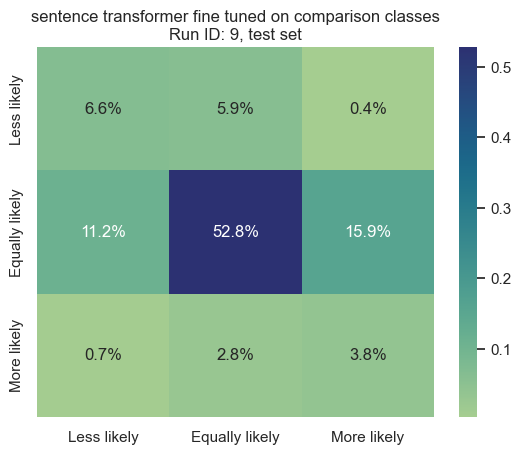

In [182]:
run_ID = 9
sns.heatmap(test_conf_matr, cmap='crest', annot=True, fmt=".1%");
plt.title(f'sentence transformer fine tuned on comparison classes\nRun ID: {run_ID}, test set');

Weighted F1

In [183]:
f1_score(y_true, y_pred, average='weighted')

0.6705749942489073

Save the model for later use

In [190]:
filename = model_name + "_" + str(run_ID) + "_" #+ "ep" +str(epochs) + "_"
if len(train[train['label'] == 1]) == 1500:
    filename += "balanced"
else: 
    filename += "full"
filename += ".pt"
print(filename)
torch.save(model, filename)

all-mpnet-base-v2_9_full.pt
